In [ ]:
!git clone https://github.com/openai/point-e.git
%cd point-e
!pwd
!pip install -q -e .

In [11]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|████████████████████████████████████████| 890M/890M [00:07<00:00, 120MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [13]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [22]:
# Load an image to condition on.
img = Image.open('point_e/examples/example_data/side_2.jpg')
img2 = Image.open('point_e/examples/example_data/front_2.jpg')
# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x

0it [00:00, ?it/s]

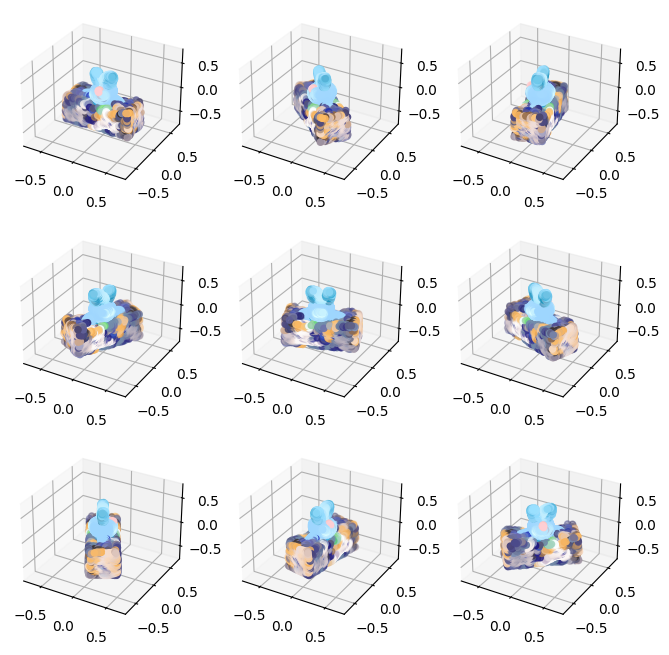

In [23]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [24]:
pc

PointCloud(coords=array([[ 0.46350196,  0.04837517, -0.29215464],
       [ 0.16727771, -0.18815248, -0.20764586],
       [ 0.4415752 ,  0.08973555, -0.0337991 ],
       ...,
       [-0.11614846, -0.01440593,  0.00461997],
       [ 0.1332781 ,  0.01991757,  0.11666346],
       [ 0.36652783,  0.13387974, -0.5       ]], dtype=float32), channels={'R': array([0.9333334 , 0.7176471 , 0.3137255 , ..., 0.62352943, 0.627451  ,
       0.7803922 ], dtype=float32), 'G': array([0.86666673, 0.7058824 , 0.29411766, ..., 0.8431373 , 0.8431373 ,
       0.7294118 ], dtype=float32), 'B': array([0.854902  , 0.81568635, 0.3647059 , ..., 1.        , 1.        ,
       0.76470596], dtype=float32)})

In [26]:
import numpy as np

In [27]:
np.savetxt('point_cloud.txt', pc.coords)